In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/detect

Mounted at /content/drive
/content/drive/MyDrive/detect


In [6]:
%tensorflow_version 1.x

In [8]:
# Most Recent One (Suggested)
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-gusbgld1
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-gusbgld1


In [10]:
!pip3 uninstall keras-nightly
!pip3 install keras==2.2.4
!pip3 install h5py==2.10.0

  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0


In [11]:
from PIL import Image
import os, sys
import cv2
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras 
from keras_vggface.vggface import VGGFace
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [12]:
vggface = VGGFace(model='vgg16')





580075520/580070376 [==============================] - 6s 0us/step








In [13]:
# FAST_RUN = False
# IMAGE_WIDTH=128
# IMAGE_HEIGHT=128
# IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
# IMAGE_CHANNELS=3

In [14]:
filenames = os.listdir("/content/drive/MyDrive/detect")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'Đức':
        categories.append(0)
    elif category == 'Hùng':
        categories.append(1)
    elif category == 'Quân':
        categories.append(2)
    elif category == 'Trường':
        categories.append(3)
    elif category == 'Việt Đức':
        categories.append(4)
    elif category == 'HĐức':
        categories.append(5)
    elif category == 'Kiên':
        categories.append(6)
    elif category == 'Tân':
        categories.append(7)
    elif category == 'Tuấn':
        categories.append(8)
    elif category == 'Xuân Anh':
        categories.append(9)
    elif category == 'Hiếu':
        categories.append(10)
    elif category == 'Linh':
        categories.append(11)
    elif category == 'Thắng':
        categories.append(12)
    else:
        categories.append(13)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df.shape

(1509, 2)

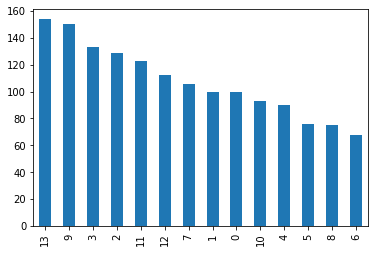

In [16]:
df['category'].value_counts().plot.bar()

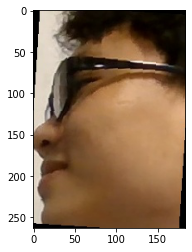

In [17]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/detect/"+sample)
plt.imshow(image)

In [18]:
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

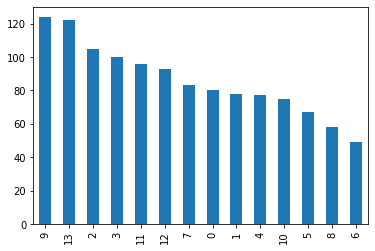

In [19]:
train_df['category'].value_counts().plot.bar()

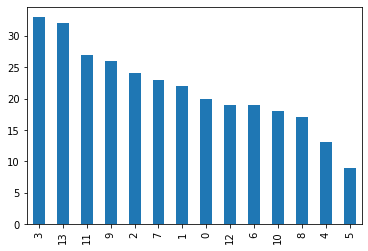

In [20]:
val_df['category'].value_counts().plot.bar()

In [21]:
print(train_df[train_df.category == 1].filename.values[1])

Hùng_0.jpg


In [22]:
label = ["Đức","Hùng","Quân","Trường","Việt Đức","HĐức","Kiên","Tân","Tuấn","Xuân Anh","Hiếu","Linh","Thắng","Vân"]

In [23]:
def show_distinct_people(images):
    unique_ids = np.unique(train_df.category.values)
    fig, axarr=plt.subplots(nrows=2, ncols=7, figsize=(18, 5))
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=random.choice(images[images.category == unique_id].filename.values)
        img = load_img("/content/drive/MyDrive/detect/"+image_index)
        img = img.resize((224,224),Image.ANTIALIAS)
        axarr[unique_id].imshow(img)
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{} - {}".format(unique_id,image_index.split('_')[0]))
    plt.suptitle("There are 14 distinct people in the dataset")

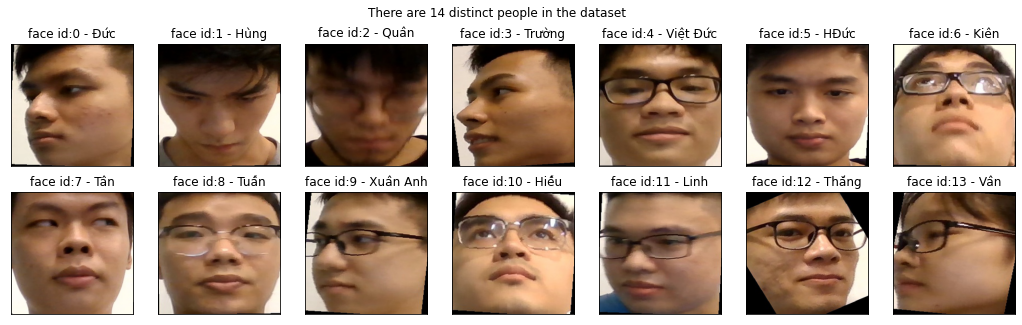

In [24]:
show_distinct_people(train_df)

In [25]:
x_train= np.array([ np.array(Image.open("/content/drive/MyDrive/detect/"+fname).resize((224,224),Image.ANTIALIAS)) for fname in train_df.filename.values])
x_val= np.array([ np.array(Image.open("/content/drive/MyDrive/detect/"+fname).resize((224,224),Image.ANTIALIAS)) for fname in val_df.filename.values])

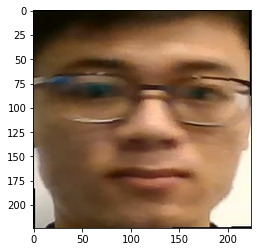

In [ ]:
# image = load_img("/content/drive/MyDrive/detect/"+sample)
plt.imshow(x_train[1])

In [26]:
y_train = tf.keras.utils.to_categorical(train_df.category.values, 14)
y_val = tf.keras.utils.to_categorical(val_df.category, 14)
x_train = x_train/255.
x_val = x_val/255.
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
y_train[1]

(1207, 224, 224, 3) (1207, 14)
(302, 224, 224, 3) (302, 14)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

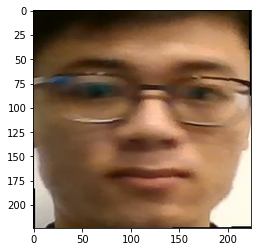

In [27]:
plt.imshow(x_train[1])

In [ ]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.optimizers import SGD

In [ ]:
nb_class = 14
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
# last_layer = vgg_model.get_layer('avg_pool').output
# x = Flatten(name='flatten')(last_layer)
# out = Dense(nb_class, activation='softmax', name='classifier')(x)
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(1024, activation='relu', name='fc6')(x)
x = Dropout(0.1)(x)
x = Dense(512, activation='relu', name='fc7')(x)
# x = Dropout(0.1)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
model = Model(vgg_model.input, out)

58916864/58909280 [==============================] - 1s 0us/step

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
sgd = SGD(lr=10e-3, momentum=0.9, decay=0.000001,)
model.compile(optimizer=sgd, loss='binary_crossentropy',metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# model = Sequential([resnet_model,
#         Dense(512, activation='relu'),
#         Dropout(0.3),
#         BatchNormalization(),
#         Dense(256, activation='relu'),
#         Dropout(0.3),
#         Dense(14, activation='softmax')                   
# ])

# sgd = SGD(learning_rate=10e-3, momentum=0.9, decay=0.000001)
# model.compile(optimizer=sgd , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/vggface.h5',
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')
erl = EarlyStopping(monitor='val_acc', patience=10)

In [ ]:
batch_size=64

In [ ]:
aug_train =ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')
# aug_train = ImageDataGenerator(rotation_range=30, shear_range=0.2,
#                                horizontal_flip=True,fill_mode='nearest')

In [ ]:
hist = model.fit_generator(aug_train.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, validation_data=(x_val, y_val), verbose=1, epochs = 200, callbacks=[erl])
model.save_weights('/content/drive/MyDrive/Colab Notebooks/vggface.h5')



Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/18 [==============================] - 60s 3s/step - loss: 0.2568 - acc: 0.9286 - val_loss: 0.2558 - val_acc: 0.9286
Epoch 2/200
18/18 [==============================] - 47s 3s/step - loss: 0.2558 - acc: 0.9286 - val_loss: 0.2536 - val_acc: 0.9286
Epoch 3/200
18/18 [==============================] - 35s 2s/step - loss: 0.2536 - acc: 0.9286 - val_loss: 0.2492 - val_acc: 0.9286
Epoch 4/200
18/18 [==============================] - 35s 2s/step - loss: 0.2479 - acc: 0.9286 - val_loss: 0.2331 - val_acc: 0.9286
Epoch 5/200
18/18 [==============================] - 35s 2s/step - loss: 0.2207 - acc: 0.9298 - val_loss: 0.1451 - val_acc: 0.9503
Epoch 6/200
18/18 [==============================] - 35s 2s/step - loss: 0.1348 - acc: 0.9521 - val_loss: 0.0580 - val_acc: 0.9797
Epoch 7/200
18/18 [==============================] - 35s 2s/step - loss: 0.0772 - acc: 0.9711 - val_loss: 0.0307 - val_acc: 0.9889
Epoch 8/200
18/18 [==============================] - 35s 2s/step - loss: 0.0423 - acc: 0.9847 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


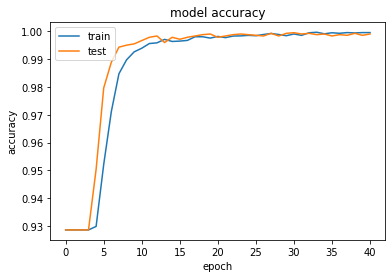

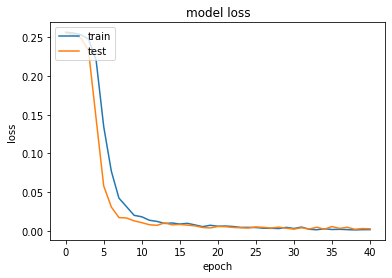

In [ ]:
H = hist 
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/vggface.h5') #vggface

In [28]:
pre = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


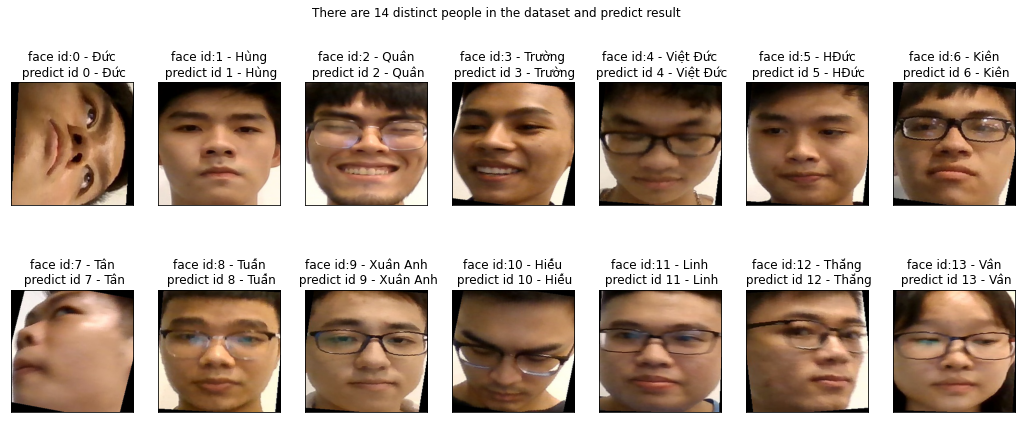

In [29]:
def pred_distinct_people(images):
    unique_ids = np.unique(train_df.category.values)
    fig, axarr=plt.subplots(nrows=2, ncols=7, figsize=(18, 7))
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=random.choice(images[images.category == unique_id].filename.values)
        img = load_img("/content/drive/MyDrive/detect/"+image_index)
        img = img.resize((224,224),Image.ANTIALIAS)
        arr = np.array([np.array(img)])
        pre1 = np.argmax(pre.predict(arr))
        axarr[unique_id].imshow(img)
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{} - {}\n predict id {} - {}".format(unique_id,image_index.split('_')[0],pre1,label[pre1]))
    plt.suptitle("There are 14 distinct people in the dataset and predict result")
pred_distinct_people(val_df)

In [30]:
score = pre.evaluate(x_val,y_val)
print(f'Test loss: {score[0]:.4f}')
print(f'Tess accuracy: {score[1]:.4f}')

302/302 [==============================] - 8s 26ms/sample - loss: 0.0059 - acc: 0.9991
Test loss: 0.0059
Tess accuracy: 0.9991


In [31]:
def pred_result(path):
  plt.figure(figsize=(5,5))
  image_index = os.path.basename(path)
  img = load_img(path)
  img = img.resize((224,224),Image.ANTIALIAS)
  arr = np.array([np.array(img)])
  pre1 = np.argmax(pre.predict(arr))
  plt.imshow(img)
  plt.title(f"predict {label[pre1]} - {image_index.split('_')[0]}")

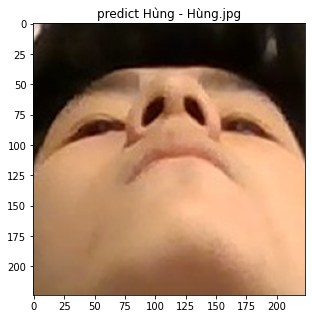

In [36]:
pred_result("/content/Hùng.jpg")